In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define the custom dataset
class CustomDataset(Dataset):
    def __init__(self, images, numerical_features, targets):
        self.images = images
        self.numerical_features = numerical_features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image = self.images[idx]
        numerical_feature = self.numerical_features[idx]
        target = self.targets[idx]
        return image, numerical_feature, target

# Define the regression model
class RegressionModel(nn.Module):
    def __init__(self, num_numerical_features):
        super(RegressionModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        # Calculate the correct input size for fc1
        self.fc1 = nn.Linear(64 * 3 * 3 + num_numerical_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, image, numerical_features):
        x = self.conv_layers(image)
        x = self.flatten(x)
        # Concatenate tensors
        x = torch.cat((x, numerical_features), dim=1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

# Function to plot learning curve
def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Learning Curve')
    plt.show()

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=7):
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, numerical_features, targets in train_loader:
            images, numerical_features, targets = images.to(device), numerical_features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images, numerical_features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, numerical_features, targets in val_loader:
                images, numerical_features, targets = images.to(device), numerical_features.to(device), targets.to(device)
                outputs = model(images, numerical_features)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load('checkpoint.pt'))
    plot_learning_curve(train_losses, val_losses)
    return model

In [4]:
with open('processed_data_minmax_normalized_trimmed.pkl', 'rb') as f:
  data = pickle.load(f)

Epoch 1/300, Training Loss: 0.0507, Validation Loss: 0.0249
Validation loss decreased (inf --> 0.024881).  Saving model ...
Epoch 2/300, Training Loss: 0.0168, Validation Loss: 0.0143
Validation loss decreased (0.024881 --> 0.014310).  Saving model ...
Epoch 3/300, Training Loss: 0.0134, Validation Loss: 0.0150
EarlyStopping counter: 1 out of 7
Epoch 4/300, Training Loss: 0.0134, Validation Loss: 0.0140
Validation loss decreased (0.014310 --> 0.013958).  Saving model ...
Epoch 5/300, Training Loss: 0.0131, Validation Loss: 0.0140
EarlyStopping counter: 1 out of 7
Epoch 6/300, Training Loss: 0.0130, Validation Loss: 0.0135
Validation loss decreased (0.013958 --> 0.013458).  Saving model ...
Epoch 7/300, Training Loss: 0.0127, Validation Loss: 0.0131
Validation loss decreased (0.013458 --> 0.013133).  Saving model ...
Epoch 8/300, Training Loss: 0.0123, Validation Loss: 0.0127
Validation loss decreased (0.013133 --> 0.012665).  Saving model ...
Epoch 9/300, Training Loss: 0.0121, Validat

C:\Users\udays\AppData\Local\Temp\ipykernel_18080\1725550424.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


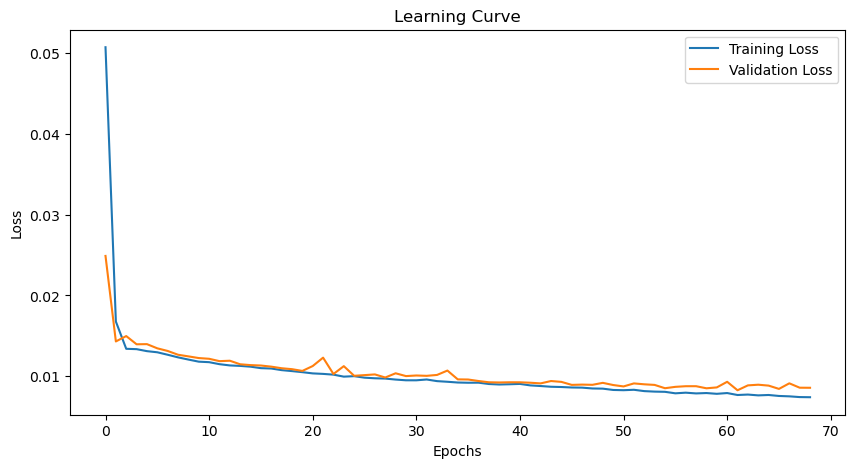

In [5]:
train_images = data['train_images'].astype(np.float32)
train_images = np.transpose(train_images, (0, 3, 1, 2))
val_images = data['val_images'].astype(np.float32)
val_images = np.transpose(val_images, (0, 3, 1, 2))
train_numerical_features = data['train_numerical_features'].astype(np.float32)
val_numerical_features = data['val_numerical_features'].astype(np.float32)
train_targets = data['train_targets'].astype(np.float32).reshape(-1, 1)
val_targets = data['val_targets'].astype(np.float32).reshape(-1, 1)

num_numerical_features = train_numerical_features.shape[1]

train_dataset = CustomDataset(train_images, train_numerical_features, train_targets)
val_dataset = CustomDataset(val_images, val_numerical_features, val_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = RegressionModel(num_numerical_features = num_numerical_features).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=300, patience=7)

In [6]:
with open('processed_test_data_minamx_normalized_trimmed.pkl', 'rb') as f:
  test_data = pickle.load(f)

In [7]:
test_images = test_data['images'].astype(np.float32)
test_images = np.transpose(test_images, (0, 1, 4, 2, 3))
test_numerical_features = test_data['numerical_features'].astype(np.float32)
metadata = test_data['metadata']

In [8]:
predictions = []
num_data_points = test_images.shape[0]

for index in range(num_data_points):

    images = test_images[index]
    numerical_features = test_numerical_features[index]
    model.eval()
    with torch.no_grad():
        images, numerical_features = torch.from_numpy(images).to(device), torch.from_numpy(numerical_features).to(device)
        output = float(torch.mean(model(images, numerical_features)*metadata['max_yield']).cpu().numpy())
    predictions.append(output)

In [9]:
f = open('test_predictions_Aug_19_minmax_normalization_trimmed.pkl', 'wb')
pickle.dump({'test_predictions': predictions},f)
f.close()